### Import data - all sessions

518 TRs x 630 parcels

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dyneusr as dy
from umap.umap_ import UMAP
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from kmapper import KeplerMapper
from hdbscan import HDBSCAN

In [2]:
from load_data import load_scrubbed
sessions = load_scrubbed(n_sessions=-1, merge=False)

INFO:load_data:load_scrubbed(**{'n_sessions': -1, 'merge': False})
INFO:load_data:Loading data...
INFO:root:  [+] session: 1, path: data/base/combined_data_scrubbed/sub014.txt
INFO:root:  [+] session: 2, path: data/base/combined_data_scrubbed/sub015.txt
INFO:root:  [+] session: 3, path: data/base/combined_data_scrubbed/sub016.txt
INFO:root:  [+] session: 4, path: data/base/combined_data_scrubbed/sub017.txt
INFO:root:  [+] session: 5, path: data/base/combined_data_scrubbed/sub018.txt
INFO:root:  [+] session: 6, path: data/base/combined_data_scrubbed/sub019.txt
INFO:root:  [+] session: 7, path: data/base/combined_data_scrubbed/sub020.txt
INFO:root:  [+] session: 8, path: data/base/combined_data_scrubbed/sub021.txt
INFO:root:  [+] session: 9, path: data/base/combined_data_scrubbed/sub022.txt
INFO:root:  [+] session: 10, path: data/base/combined_data_scrubbed/sub023.txt
INFO:root:  [+] session: 11, path: data/base/combined_data_scrubbed/sub024.txt
INFO:root:  [+] session: 12, path: data/ba

In [32]:
sessions[78].X.shape

(518, 630)

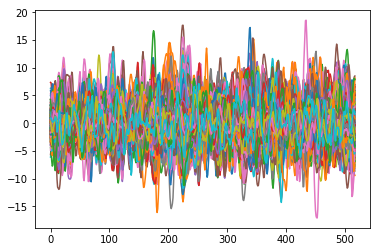

In [12]:
plt.close('all')
plt.plot(sessions[0].X)
plt.show()

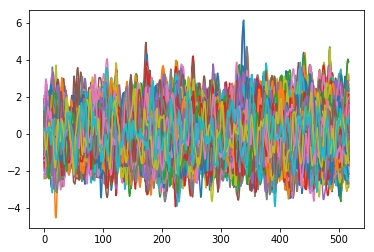

In [13]:
from scipy.stats import zscore
Xz = zscore(sessions[0].X,axis=0)
plt.close('all')
plt.plot(Xz)
plt.show()

### Import resting state network parcellation labels

In [18]:
df_parcel = pd.read_table('data/base/parcellation/parcel_data.txt',header=None)
rsn = pd.factorize(df_parcel.iloc[:,7])

dmn = df_parcel.index[df_parcel[7] == 'DMN'].tolist()
dan = df_parcel.index[df_parcel[7] == 'Dorsal_Attention'].tolist()
van = df_parcel.index[df_parcel[7] == 'Ventral_Attention'].tolist()
fp1 = df_parcel.index[df_parcel[7] == 'Frontoparietal_1'].tolist()
cing = df_parcel.index[df_parcel[7] == 'Cingulo_opercular'].tolist()
sal = df_parcel.index[df_parcel[7] == 'Salience'].tolist()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x13f9de7f0>,
      dtype=object)

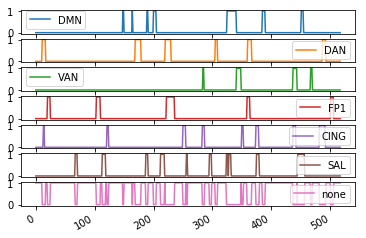

In [36]:
rsn_act = np.zeros((Xz.shape[0],7))
thres = 1
for tr,t in enumerate(Xz):
    # Get average RSN activity of five networks
    activity = np.array([np.mean(t[dmn]), np.mean(t[dan]), np.mean(t[van]), np.mean(t[fp1]), np.mean(t[cing]), np.mean(t[sal])])
    # Set those columns to true
    activation = np.argwhere(activity>thres).flatten()
    if activation.size != 0:
        rsn_act[tr,activation] = 1
    else:
        rsn_act[tr,6] = 1
        
df_rsn = pd.DataFrame(rsn_act,columns=['DMN','DAN','VAN','FP1','CING', 'SAL', 'none'])
df_rsn.plot(subplots=True)

### Create a test mapper for a session to optimize resolution and gain

In [42]:
mapper = KeplerMapper(verbose=1)
lens = mapper.fit_transform(Xz, projection=TSNE(random_state=420))
graph = mapper.map(lens, Xz, clusterer=HDBSCAN(allow_single_cluster=True), nr_cubes=10, overlap_perc=0.6)

..Composing projection pipeline length 1:
Projections: TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=300,
   perplexity=30.0, random_state=420, verbose=0)


Distance matrices: False


Scalers: MinMaxScaler(copy=True, feature_range=(0, 1))


..Projecting on data shaped (518, 630)

..Projecting data using: 
	TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=300,
   perplexity=30.0, random_state=420, verbose=1)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 518 samples in 0.006s...
[t-SNE] Computed neighbors for 518 samples in 0.388s...
[t-SNE] Computed conditional probabilities for sample 518 / 518
[t-SNE] Mean sigma: 11.973588
[t-SNE] KL divergence after 250 iterations with early 

In [49]:
from pprint import pprint
labels = {_:[str(_)+' not active', str(_)+' is active'] for _ in df_rsn.columns}
pprint(labels)

{'CING': ['CING not active', 'CING is active'],
 'DAN': ['DAN not active', 'DAN is active'],
 'DMN': ['DMN not active', 'DMN is active'],
 'FP1': ['FP1 not active', 'FP1 is active'],
 'SAL': ['SAL not active', 'SAL is active'],
 'VAN': ['VAN not active', 'VAN is active'],
 'none': ['none not active', 'none is active']}


In [50]:
# Fit DyNeuGraph
dyneuG = dy.DyNeuGraph()
dyneuG.fit(G=graph,y=df_rsn, labels=labels)

Processing meta column: DMN
  [+] found 2 unique groups.
Processing meta column: DAN
  [+] found 2 unique groups.
Processing meta column: VAN
  [+] found 2 unique groups.
Processing meta column: FP1
  [+] found 2 unique groups.
Processing meta column: CING
  [+] found 2 unique groups.
Processing meta column: SAL
  [+] found 2 unique groups.
Processing meta column: none
  [+] found 2 unique groups.
Processing meta column: data_id
  [+] found 5 unique groups.
Processing meta column: default
  [+] found 1 unique groups.
1.0


DyNeuGraph()

In [51]:
dyneuG.visualize(path_html='test2.html', show=False, reset=True, static=False, PORT=8800)

[Force Graph] http://localhost:8800/test2.html


DyNeuGraph()

### Import behavioral data

In [ ]:
df = pd.read_table('data/base/behavior/trackingdata_goodscans.txt')

What if we compared Mappers between scans with good and bad sleep quality?

In [24]:
df['morning:Sleepquality'] = pd.to_numeric(df['morning:Sleepquality'],errors='coerce')
df[df['morning:Sleepquality'] > 4]

,subcode,date,afterscan:Anxietyduringscan,afterscan:diastolic,afterscan:pulse,afterscan:systolic,blood:ba,blood:eo,blood:hgb,blood:ly,...,scan:noisecancel,weather:precip,weather:temphi,weather:templo,weight,zeo:timeInDeep,zeo:timeInLight,zeo:timeInRem,zeo:totalZ,zeo:zq
67,sub086,2013-10-22,5,75,68,109,.,.,.,.,...,1,0.0,77,54,149.78,.,.,.,.,.
69,sub088,2013-10-29,5,73,70,127,.,.,.,.,...,1,0.0,84,71,151.00,144.5,198.0,149.5,492.0,108


In [27]:
df[df['morning:Sleepquality'] <= 1]

,subcode,date,afterscan:Anxietyduringscan,afterscan:diastolic,afterscan:pulse,afterscan:systolic,blood:ba,blood:eo,blood:hgb,blood:ly,...,scan:noisecancel,weather:precip,weather:temphi,weather:templo,weight,zeo:timeInDeep,zeo:timeInLight,zeo:timeInRem,zeo:totalZ,zeo:zq
12,sub026,2012-11-27,3,79,82,136,0.0,0.2,14.0,1.5,...,1,0.00,60,40,147.53,137,147,106,389,88
25,sub042,2013-01-29,5,77,68,119,.,.,.,.,...,0,0.01,84,57,148.65,78,211,92,380,72
63,sub082,2013-10-03,5,76,73,115,.,.,.,.,...,1,0.00,93,76,151.43,128.5,213.5,134.0,476.0,103
70,sub089,2013-10-31,6,76,81,122,.,.,.,.,...,1,1.43,82,54,150.06,81.5,237.0,121.5,440.0,86


In [34]:
print(df.iloc[69,:].to_string())

subcode                                              sub088
date                                             2013-10-29
afterscan:Anxietyduringscan                               5
afterscan:diastolic                                      73
afterscan:pulse                                          70
afterscan:systolic                                      127
blood:ba                                                  .
blood:eo                                                  .
blood:hgb                                                 .
blood:ly                                                  .
blood:mch                                                 .
blood:mchc                                                .
blood:mcv                                                 .
blood:mo                                                  .
blood:mpv                                                 .
blood:ne                                                  .
blood:plt                               

In [35]:
print(df.iloc[70,:].to_string())

subcode                                              sub089
date                                             2013-10-31
afterscan:Anxietyduringscan                               6
afterscan:diastolic                                      76
afterscan:pulse                                          81
afterscan:systolic                                      122
blood:ba                                                  .
blood:eo                                                  .
blood:hgb                                                 .
blood:ly                                                  .
blood:mch                                                 .
blood:mchc                                                .
blood:mcv                                                 .
blood:mo                                                  .
blood:mpv                                                 .
blood:ne                                                  .
blood:plt                               

In [71]:
from collections import Counter
meta = np.array([[0,1],[1],[0,2],[2],[1],[0,3]])
groups = list(meta)
if type(groups[0]) is list:
    A = [el for sublist in groups for el in sublist]
meta

array([list([0, 1]), list([1]), list([0, 2]), list([2]), list([1]),
       list([0, 3])], dtype=object)

In [77]:
type(meta[0]) is list

True